참고 링크 : https://keras.io/examples/vision/handwriting_recognition/

# 준비

In [108]:
import os
import gc
import shutil
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental.preprocessing import StringLookup

## 데이터

In [5]:
# 다운로드
!curl -LO https://git.io/J0fjL -O IAM_Words.zip
print("다운로드 완료")

# 파일 이동
shutil.move("J0fjL", "D:Dataset/dataset/Kaggle/")
print("파일 이동 완료")

# 압축해제
with zipfile.ZipFile("D:Dataset/dataset/Kaggle/J0fjL","r") as zip_ref:
    zip_ref.extractall("D:Dataset/dataset/Kaggle/")
print("압축 해제 완료")

# 압축해제
with tarfile.open("D:Dataset/dataset/Kaggle/IAM_Words/words.tgz","r:gz") as tar_ref:
    tar_ref.extractall("D:Dataset/dataset/Kaggle/IAM_Words")
print("압축 해제 완료")

# 압축파일 제거
os.remove("D:Dataset/dataset/Kaggle/J0fjL")
print("압축파일 제거 완료")

# 압축파일 제거
os.remove("D:Dataset/dataset/Kaggle/IAM_Words/words.tgz")
print("압축파일 제거 완료")

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0

  0  783M    0  2742    0     0   1176      0   8d 02h  0:00:02   8d 02h  1176
  0  783M    0 5103k    0     0  1725k      0  0:07:45  0:00:02  0:07:43 8122k
  1  783M    1 15.4M    0     0  4012k      0  0:03:19  0:00:03  0:03:16 9765k
  3  783M    3 25.9M    0     0  5363k      0  0:02:29  0:00:04  0:02:25  9.8M
  4  783M    4 35.5M    0     0  6103k      0  0:02:11  0:00:05  0:02:06  9.7M
  5  783M    5 45.1M    0     0  6641k      0  0:02:00  0:00:06  0:01:54 9986k
  6  783M    6 54.0M    0     0  6962k      0  0:

다운로드 완료
파일 이동 완료
압축 해제 완료
압축 해제 완료
압축파일 제거 완료
압축파일 제거 완료


In [48]:
total_img = glob("D:/Dataset/dataset/Kaggle/IAM_Words/*/*/*.png")
print("Total img count\t:",len(total_img))
print("Sample\t\t\t:", total_img[0])

for i in total_img:
    shutil.move(i,"D:/Dataset/dataset/Kaggle/IAM_Words/words/")
print(f"{len(total_img)}개 이미지, 이동 완료")

Total img count	: 115320
Sample			: D:/Dataset/dataset/Kaggle/IAM_Words\a01\a01-000u\a01-000u-00-00.png
115320 imgs moved


In [17]:
# file header 확인
file = open("D:/Dataset/dataset/Kaggle/IAM_Words/words.txt", "r")
for i in range(20):
    line = file.readline()
    print(line)
file.close()

#--- words.txt ---------------------------------------------------------------#

#

# iam database word information

#

# format: a01-000u-00-00 ok 154 1 408 768 27 51 AT A

#

#     a01-000u-00-00  -> word id for line 00 in form a01-000u

#     ok              -> result of word segmentation

#                            ok: word was correctly

#                            er: segmentation of word can be bad

#

#     154             -> graylevel to binarize the line containing this word

#     1               -> number of components for this word

#     408 768 27 51   -> bounding box around this word in x,y,w,h format

#     AT              -> the grammatical tag for this word, see the

#                        file tagset.txt for an explanation

#     A               -> the transcription for this word

#

a01-000u-00-00 ok 154 408 768 27 51 AT A

a01-000u-00-01 ok 154 507 766 213 48 NN MOVE



## 데이터 전처리 + TTS

In [31]:
# 데이터 정보가 있는 line 추출
base_path = "D:Dataset/dataset/Kaggle/IAM_Words"
words_list = []

words = open(f"{base_path}/words.txt", "r").readlines()
for line in words:
    if line[0] == "#":
        continue
    if line.split(" ")[1] != "err":  # We don't need to deal with errored entries.
        words_list.append(line)

np.random.shuffle(words_list) # 데이터 Shuffle
print(words_list[:10])

['e04-004-02-09 ok 157 1880 1084 154 89 NN piece\n', 'r06-103-07-00 ok 183 344 1987 98 95 IN off\n', 'a04-019-03-08 ok 172 1769 1452 145 110 VBN given\n', 'l07-135-01-06 ok 179 1685 1106 164 73 AT an\n', 'a04-089-04-01 ok 172 536 1615 525 89 NN establishment\n', 'b01-062-07-03 ok 162 1462 2066 9 8 . .\n', 'g06-037i-07-04 ok 162 1217 2024 287 93 NNS symptoms\n', 'a06-095-00-05 ok 182 1655 694 107 114 BE be\n', 'b04-175-03-04 ok 182 1672 1277 190 73 NN virtue\n', 'h07-060a-05-05 ok 163 1306 1583 147 67 HV have\n']


In [37]:
split_idx = int(0.9 * len(words_list))
train_samples = words_list[:split_idx]
test_samples = words_list[split_idx:]

val_split_idx = int(0.5 * len(test_samples))
validation_samples = test_samples[:val_split_idx]
test_samples = test_samples[val_split_idx:]

assert len(words_list) == len(train_samples) + len(validation_samples) + len(test_samples)

print(f"Total training samples\t\t: {len(train_samples)}")
print(f"Total validation samples\t: {len(validation_samples)}")
print(f"Total test samples\t\t\t: {len(test_samples)}")

Total training samples		: 86810
Total validation samples	: 4823
Total test samples			: 4823


## Input pipeline

In [111]:
batch_size = 64
padding_token = 99
image_width = 128
image_height = 32

### img_path 와 img 정보

In [65]:
base_image_path = os.path.join(base_path, "words")

# 데이터 정보가 담긴 line(sample) 에서 이미지path 와 정보 추출
def get_image_paths_and_labels(samples):
    paths = []
    corrected_samples = []
    for (i, file_line) in enumerate(samples):
        line_split = file_line.strip()
        line_split = line_split.split(" ")

        # Each line split will have this format for the corresponding image:
        # part1/part1-part2/part1-part2-part3.png
        image_name = line_split[0]
        img_path = os.path.join( base_image_path,  image_name + ".png")
        if os.path.getsize(img_path):
            paths.append(img_path)
            corrected_samples.append(file_line.split("\n")[0])

    return paths, corrected_samples

In [71]:
train_img_paths, train_labels = get_image_paths_and_labels(train_samples)
validation_img_paths, validation_labels = get_image_paths_and_labels(validation_samples)
test_img_paths, test_labels = get_image_paths_and_labels(test_samples)
print(f"Total training img count \t: {len(train_img_paths)}")
print(f"Total validation img count\t: {len(validation_img_paths)}")
print(f"Total test img count\t\t: {len(test_img_paths)}")

Total training img count 	: 86808
Total validation img count	: 4823
Total test img count		: 4823


In [76]:
train_labels[0].split(" ")[-1].strip()

'piece'

### img 정보에서 label, vocabulary_char 생성

In [83]:
# Find maximum length and the size of the vocabulary in the training data.
train_labels_cleaned = []
characters = set()
max_len = 0

# img의 정보 중에서 label 값 추출
for label in train_labels:
    label = label.split(" ")[-1].strip()
    # label 철자 추출
    for char in label: 
        characters.add(char)

    # 최대 길이 확인
    max_len = max(max_len, len(label))
    
    # label list
    train_labels_cleaned.append(label)

#알파벳
characters = sorted(list(characters))
print("Maximum length\t\t:", max_len)
print("Vocab size\t\t\t:", len(characters))
print(f"Train_labels samples \t:", train_labels_cleaned[:10])

Maximum length		: 21
Vocab size			: 78
Train_labels samples 	: ['piece', 'off', 'given', 'an', 'establishment', '.', 'symptoms', 'be', 'virtue', 'have']


In [84]:
def clean_labels(labels):
    cleaned_labels = []
    for label in labels:
        label = label.split(" ")[-1].strip()
        cleaned_labels.append(label)
    return cleaned_labels

validation_labels_cleaned = clean_labels(validation_labels)
test_labels_cleaned = clean_labels(test_labels)

### character vocabulary 생성

In [85]:
AUTOTUNE = tf.data.AUTOTUNE

char_to_num = StringLookup(vocabulary=list(characters), mask_token=None)
num_to_char = StringLookup(vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True)

## Helper function

### 이미지 사이즈 조절

In [88]:
def distortion_free_resize(image, img_size):
    w, h = img_size
    image = tf.image.resize(image, size=(h, w), preserve_aspect_ratio=True) # 종횡비 유지 - 맞지 않을시 확대, Crop 하여 맞춤

    pad_height = h - tf.shape(image)[0]
    pad_width = w - tf.shape(image)[1]

    # 양방향으로 padding 하기
    if pad_height % 2 != 0:
        height = pad_height // 2
        pad_height_top = height + 1 # 상향 패딩량
        pad_height_bottom = height # 하향 패딩량
    else:
        pad_height_top = pad_height_bottom = pad_height // 2 # 상/하 패딩량

    if pad_width % 2 != 0:
        width = pad_width // 2
        pad_width_left = width + 1 # 좌향 패딩량
        pad_width_right = width # 우향 패딩량
    else:
        pad_width_left = pad_width_right = pad_width // 2 # 좌/우 패딩량

    image = tf.pad(
        image,
        paddings=[
            [pad_height_top, pad_height_bottom], # 상하 패딩
            [pad_width_left, pad_width_right], # 좌우 패딩
            [0, 0], # 채널은 패딩 X
        ],
    )

    image = tf.transpose(image, perm=[1, 0, 2]) # h,w, ch -> w, h ,ch
    image = tf.image.flip_left_right(image) # 좌우 반전
    return image

### img_path -> img

In [91]:
def preprocess_image(image_path, img_size=(image_width, image_height)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, 1)
    image = distortion_free_resize(image, img_size)
    image = tf.cast(image, tf.float32) / 255.0
    return image

### 단어 임베딩

In [96]:
tf.strings.unicode_split(train_labels_cleaned[0], input_encoding="UTF-8")

<tf.Tensor: shape=(5,), dtype=string, numpy=array([b'p', b'i', b'e', b'c', b'e'], dtype=object)>

In [97]:
char_to_num(tf.strings.unicode_split(train_labels_cleaned[0], input_encoding="UTF-8"))

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([68, 61, 57, 55, 57], dtype=int64)>

In [98]:
def vectorize_label(label):
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    length = tf.shape(label)[0]
    pad_amount = max_len - length
    label = tf.pad(label, paddings=[[0, pad_amount]], constant_values=padding_token) # 좌는 pad=0, 우 pad = pad_amount, padding values 는 99
    return label

### Dataset : img 와 label 

In [103]:
def process_images_labels(image_path, label):
    image = preprocess_image(image_path)
    label = vectorize_label(label)
    return {"image": image, "label": label}

def prepare_dataset(image_paths, labels):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels)).map(process_images_labels, num_parallel_calls=AUTOTUNE)
    return dataset.batch(batch_size).cache().prefetch(AUTOTUNE)

## 데이터 셋

In [105]:
train_ds = prepare_dataset(train_img_paths, train_labels_cleaned)
validation_ds = prepare_dataset(validation_img_paths, validation_labels_cleaned)
test_ds = prepare_dataset(test_img_paths, test_labels_cleaned)

## 샘플 확인

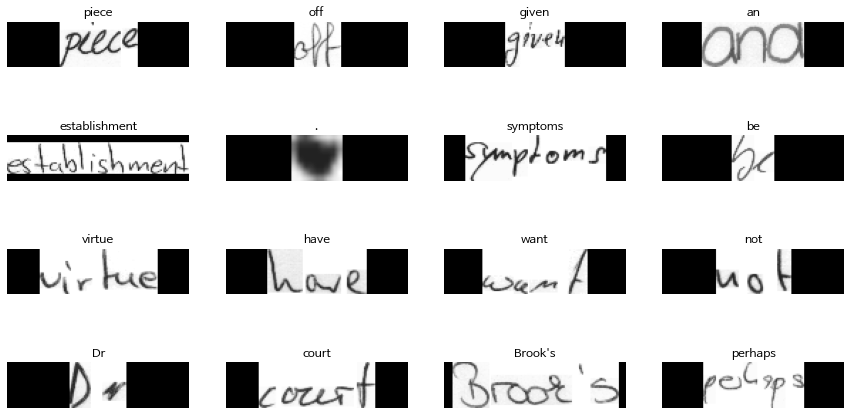

In [106]:
for data in train_ds.take(1):
    images, labels = data["image"], data["label"]

    _, ax = plt.subplots(4, 4, figsize=(15, 8))

    for i in range(16):
        img = images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        # Gather indices where label!= padding_token.
        label = labels[i]
        indices = tf.gather(label, tf.where(tf.math.not_equal(label, padding_token)))
        # Convert to string.
        label = tf.strings.reduce_join(num_to_char(indices))
        label = label.numpy().decode("utf-8")

        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")

plt.show()

# 모델

In [126]:
class CTCLayer(keras.layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)
        
        return y_pred


def build_model():
    # Inputs to the model
    input_img = keras.Input(shape=(image_width, image_height, 1), name="image")
    labels = keras.layers.Input(name="label", shape=(None,))

    # Conv block 1 -> downsampling (1/2)
    x = layers.Conv2D(32, (3, 3),
        activation="leaky_relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    x = layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Conv block 2 -> downsampling (1/2)
    x = layers.Conv2D(64, (3, 3),
        activation="leaky_relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    x = layers.MaxPooling2D((2, 2), name="pool2")(x)

    # x reshape
    new_shape = ((image_width // 4), (image_height // 4) * 64)
    x = layers.Reshape(target_shape=new_shape, name="reshape")(x)
    
    # Dense
    x = layers.Dense(64, activation="relu", name="dense1")(x)
    x = layers.Dropout(0.2)(x)

    # RNNs
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

    # Output layer
    x = keras.layers.Dense(len(char_to_num.get_vocabulary()) + 2, activation="softmax", name="dense2")(x)

    # CTC loss layer
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define the model.
    model = keras.models.Model(inputs=[input_img, labels], outputs=output, name="handwriting_recognizer")
    
    # Optimizer.
    opt = tf.keras.optimizers.Adam()
    
    # Compile the model and return.
    model.compile(optimizer=opt)
    return model


# Get the model.
model = build_model()
model.summary()

Model: "handwriting_recognizer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 128, 32, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 Conv1 (Conv2D)                 (None, 128, 32, 32)  320         ['image[0][0]']                  
                                                                                                  
 pool1 (MaxPooling2D)           (None, 64, 16, 32)   0           ['Conv1[0][0]']                  
                                                                                                  
 Conv2 (Conv2D)                 (None, 64, 16, 64)   18496       ['pool1[0][0

# 훈련

## Metric

In [127]:
validation_images = []
validation_labels = []

for batch in validation_ds:
    validation_images.append(batch["image"])
    validation_labels.append(batch["label"])

def calculate_edit_distance(labels, predictions):
    # Get a single batch and convert its labels to sparse tensors.
    saprse_labels = tf.cast(tf.sparse.from_dense(labels), dtype=tf.int64)

    # Make predictions and convert them to sparse tensors.
    input_len = np.ones(predictions.shape[0]) * predictions.shape[1]
    predictions_decoded = keras.backend.ctc_decode(
        predictions, input_length=input_len, greedy=True)[0][0][:, :max_len]
    sparse_predictions = tf.cast(tf.sparse.from_dense(predictions_decoded),
                                 dtype=tf.int64)

    # Compute individual edit distances and average them out.
    edit_distances = tf.edit_distance(sparse_predictions,
                                      saprse_labels,
                                      normalize=False)
    return tf.reduce_mean(edit_distances)


class EditDistanceCallback(keras.callbacks.Callback):

    def __init__(self, pred_model):
        super().__init__()
        self.prediction_model = pred_model

    def on_epoch_end(self, epoch, logs=None):
        edit_distances = []

        for i in range(len(validation_images)):
            labels = validation_labels[i]
            predictions = self.prediction_model.predict(validation_images[i],verbose=0)
            edit_distances.append(
                calculate_edit_distance(labels, predictions).numpy())

        print(
            f"Mean edit distance for epoch {epoch + 1}: {np.mean(edit_distances):.4f}"
        )

In [128]:
epochs = 70  # To get good results this should be at least 50.

model = build_model()
prediction_model = keras.models.Model(
    model.get_layer(name="image").input,
    model.get_layer(name="dense2").output)
edit_distance_callback = EditDistanceCallback(prediction_model)

In [129]:
# Train the model.
history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=epochs,
    callbacks=[edit_distance_callback],
)

Epoch 1/70
1357/1357 [==============================] - 64s 44ms/step - loss: 13.5089 - val_loss: 11.5393
Epoch 2/70
1357/1357 [==============================] - 54s 39ms/step - loss: 10.3900 - val_loss: 9.2215
Epoch 3/70
1357/1357 [==============================] - 57s 42ms/step - loss: 8.4428 - val_loss: 7.0054
Epoch 4/70
1357/1357 [==============================] - 54s 40ms/step - loss: 6.8017 - val_loss: 5.4638
Epoch 5/70
1357/1357 [==============================] - 54s 40ms/step - loss: 5.6073 - val_loss: 4.4126
Epoch 6/70
1357/1357 [==============================] - 54s 40ms/step - loss: 4.7925 - val_loss: 3.7559
Epoch 7/70
1357/1357 [==============================] - 53s 39ms/step - loss: 4.2409 - val_loss: 3.4072
Epoch 8/70
1357/1357 [==============================] - 54s 40ms/step - loss: 3.8914 - val_loss: 3.1523
Epoch 9/70
1357/1357 [==============================] - 53s 39ms/step - loss: 3.6081 - val_loss: 2.9206
Epoch 10/70
1357/1357 [==============================] - 53s 

Epoch 40/70
1357/1357 [==============================] - 52s 38ms/step - loss: 1.7871 - val_loss: 1.7912
Epoch 41/70
1357/1357 [==============================] - 53s 39ms/step - loss: 1.7757 - val_loss: 1.7971
Epoch 42/70
1357/1357 [==============================] - 53s 39ms/step - loss: 1.7705 - val_loss: 1.7738
Epoch 43/70
1357/1357 [==============================] - 53s 39ms/step - loss: 1.7380 - val_loss: 1.7591
Epoch 44/70
1357/1357 [==============================] - 53s 39ms/step - loss: 1.7324 - val_loss: 1.7340
Epoch 45/70
1357/1357 [==============================] - 53s 39ms/step - loss: 1.7154 - val_loss: 1.8099
Epoch 46/70
1357/1357 [==============================] - 54s 40ms/step - loss: 1.6997 - val_loss: 1.7818
Epoch 47/70
1357/1357 [==============================] - 54s 40ms/step - loss: 1.6777 - val_loss: 1.7873
Epoch 48/70
1357/1357 [==============================] - 53s 39ms/step - loss: 1.6775 - val_loss: 1.7377
Epoch 49/70
1357/1357 [==============================] 

# predict

In [130]:
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search.
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_len
    ]
    # Iterate over the results and get back the text.
    output_text = []
    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text

2/2 [==============================] - 0s 33ms/step


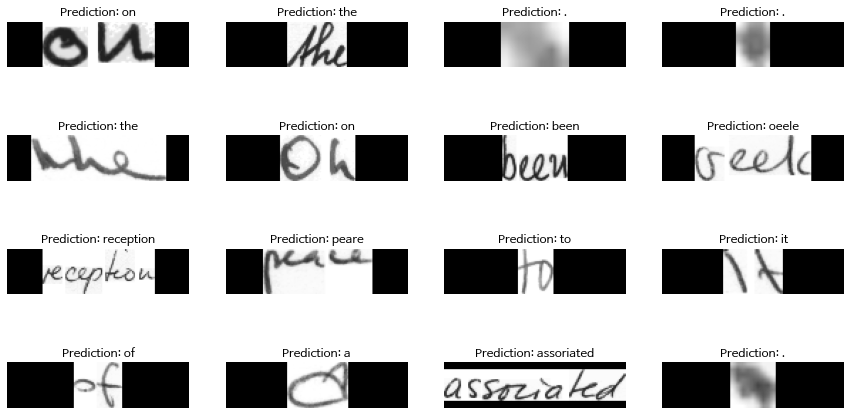

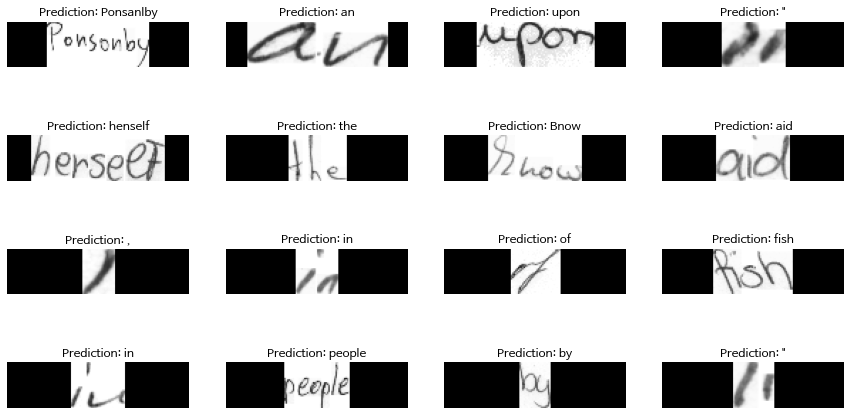

In [136]:
for batch in test_ds.take(2):
    batch_images = batch["image"]
    _, ax = plt.subplots(4, 4, figsize=(15, 8))

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    for i in range(16):
        img = batch_images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")

plt.show()

* 여전히 예측에 실패한 이미지가 있지만 육안으로 봐도 알아보기 힘든 경우인 것으로 보인다.